In [1]:
import sys
#!{sys.executable} -m pip install keras pandas numpy image matplotlib scikit-learn

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
print(os.listdir("./data"))

['test1', 'train']


In [4]:
FAST_RUN = False
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3

In [5]:
filenames = os.listdir("./data/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'algal':
        categories.append(1)
    else:
        categories.append(0)
        
df = pd.DataFrame({
    'filename':filenames,
    'category':categories
})
    

In [6]:
df.head()

,filename,category
0,algal.1.jpg,1
1,algal.10.jpg,1
2,algal.100.jpg,1
3,algal.101.jpg,1
4,algal.102.jpg,1


In [7]:
df.tail()

,filename,category
916,non_algal.95.jpg,0
917,non_algal.96.jpg,0
918,non_algal.97.jpg,0
919,non_algal.98.jpg,0
920,non_algal.99.jpg,0


<AxesSubplot:>

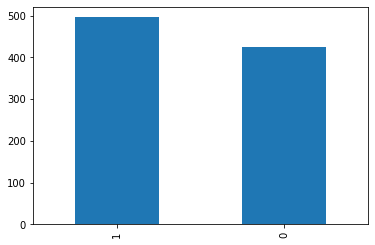

In [8]:
df['category'].value_counts().plot.bar()

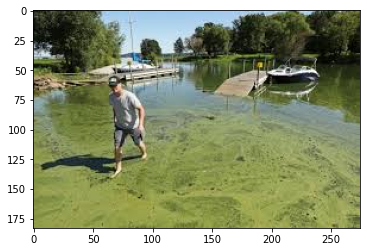

In [9]:
sample = random.choice(filenames)
image = load_img("./data/train/"+sample)
plt.imshow(image)

In [10]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

In [11]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [12]:
earlystop = EarlyStopping(patience=20)

In [13]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                           patience=2,
                                           verbose=1,
                                           factor=0.5,
                                           min_lr=0.00001)

In [14]:
callbacks = [earlystop, learning_rate_reduction]

In [15]:
df["category"] = df["category"].replace({0: 'non_algal', 1: 'algal'})

In [16]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<AxesSubplot:>

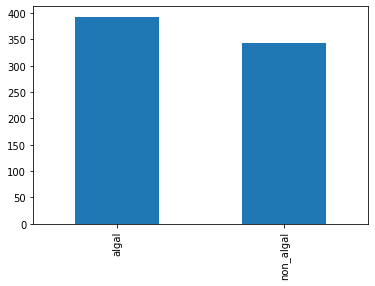

In [17]:
train_df['category'].value_counts().plot.bar()

<AxesSubplot:>

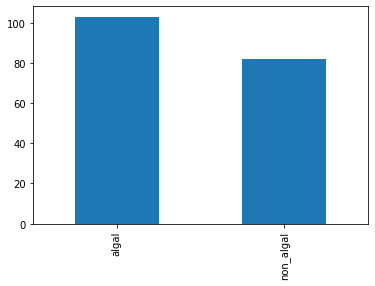

In [18]:
validate_df['category'].value_counts().plot.bar()

In [19]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size = 15

In [20]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    "./data/train/",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 736 validated image filenames belonging to 2 classes.


In [21]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    "./data/train/",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 185 validated image filenames belonging to 2 classes.


In [22]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df,
    "./data/train/",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 1 validated image filenames belonging to 1 classes.


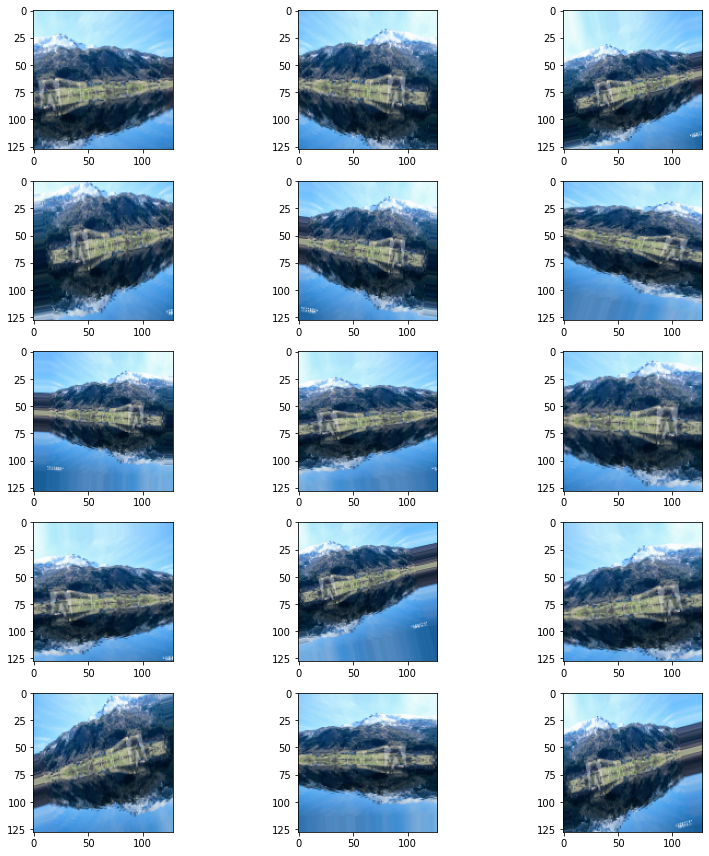

In [23]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [24]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/50
49/49 [==============================] - 30s 347ms/step - loss: 1.4795 - accuracy: 0.6903 - val_loss: 0.6660 - val_accuracy: 0.6278
Epoch 2/50
49/49 [==============================] - 17s 344ms/step - loss: 0.7925 - accuracy: 0.7125 - val_loss: 0.8926 - val_accuracy: 0.5611
Epoch 3/50
49/49 [==============================] - 18s 357ms/step - loss: 0.6684 - accuracy: 0.7606 - val_loss: 0.6847 - val_accuracy: 0.6167
Epoch 4/50
49/49 [==============================] - 19s 380ms/step - loss: 0.6453 - accuracy: 0.7496 - val_loss: 0.8049 - val_accuracy: 0.5778
Epoch 5/50
49/49 [==============================] - 19s 377ms/step - loss: 0.5910 - accuracy: 0.7544 - val_loss: 0.4708 - val_accuracy: 0.7667
Epoch 6/50
49/49 [==============================] - 19s 393ms/step - loss: 0.5438 - accuracy: 0.7727 - val_loss: 0.5761 - val_accuracy: 0.7056
Epoch 7/50
49/49 [==============================] - 21s 425ms/step - loss: 0.5488 - accuracy: 0.7572 - val_loss: 0.4988 - val_accuracy: 0.7833

Epoch 28/50
49/49 [==============================] - 19s 378ms/step - loss: 0.3109 - accuracy: 0.8758 - val_loss: 0.3903 - val_accuracy: 0.8167
Epoch 29/50
49/49 [==============================] - 18s 376ms/step - loss: 0.3003 - accuracy: 0.8675 - val_loss: 0.5136 - val_accuracy: 0.7889


In [25]:
model.save_weights("model.h5")

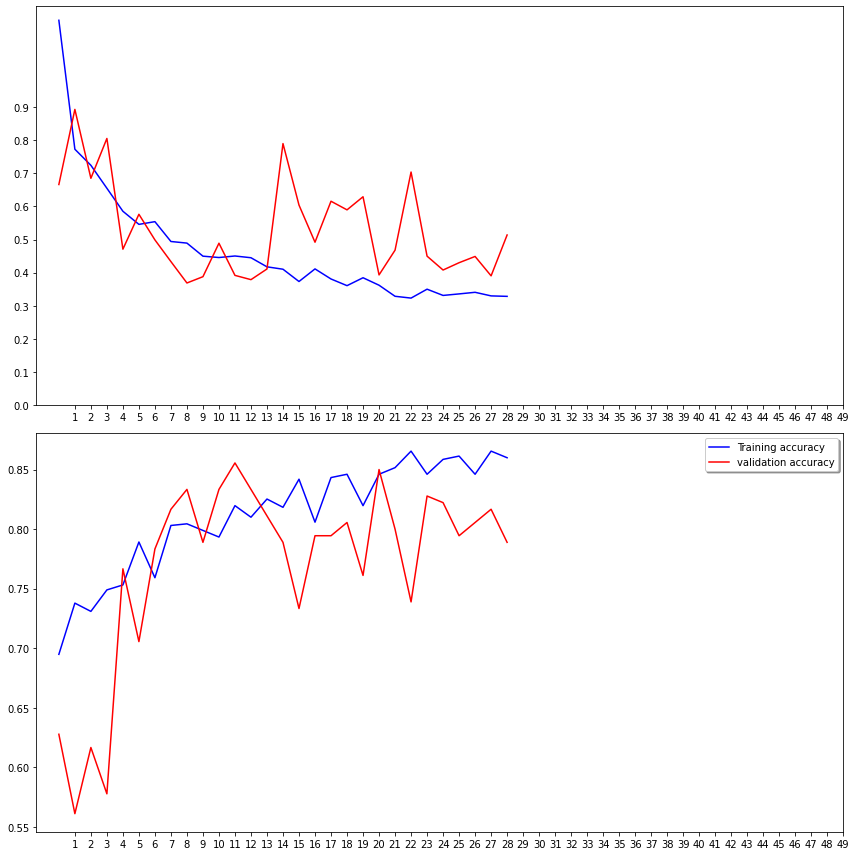

In [26]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r', label="validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

Test

In [49]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time
driver = webdriver.Chrome("C:/Users/admin/Desktop/Crawling/chromedriver.exe")
driver.get("http://3.34.140.3:8080/images" )
time.sleep(3)
#페이지 스크롤 다운
body = driver.find_element_by_css_selector('body')
for i in range(10):
    body.send_keys(Keys.PAGE_DOWN)
    time.sleep(1)
images = driver.find_elements_by_css_selector("img")
img_url = []
for image in images :
    url = image.get_attribute('src')
    img_url.append(url)
# print(img_url)
import os
from urllib.request import urlretrieve
img_folder = './no'
if not os.path.isdir(img_folder) : # 없으면 새로 생성하는 조건문
    os.mkdir(img_folder)
for index, link in enumerate(img_url) :
#     start = link.rfind('.')
#     end = link.rfind('&')
#     filetype = link[start:end]
	urlretrieve(link, f'C:/Users/admin/Desktop/last/data/test1/{index}.jpg')
driver.close()

In [50]:
test_filenames = os.listdir("./data/test1/")
#test_filenames = os.listdir("C:/Users/admin/Downloads/test1")
test_df = pd.DataFrame({
    'filename':test_filenames
})
nb_samples = test_df.shape[0]

In [51]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df,
    "./data/test1/",
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 2 validated image filenames.


In [52]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

In [53]:
test_df['category'] = np.argmax(predict, axis=-1)

In [54]:
test_df['category'] = test_df['category'].replace({1:'algal', 0:'non_algal'})

<AxesSubplot:>

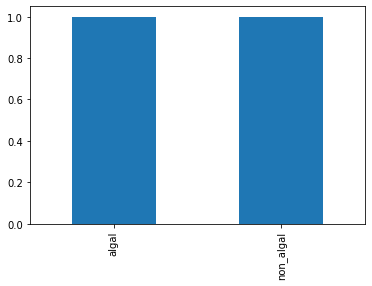

In [55]:
test_df['category'].value_counts().plot.bar()

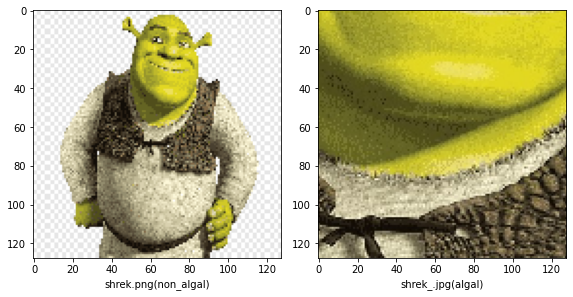

In [56]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12,24))

for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("./data/test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
#plt.show()
plt.savefig("result.jpg")
